In [1]:
import numpy as np              
from time import time
from os import listdir
from glob import glob
import cv2
import os 
import scipy.linalg as sg
from PIL import Image
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from math import sqrt
%matplotlib inline
import tensorflow as tf
from tqdm import tqdm

In [30]:
def pintar(cov):
    new_cov=np.copy(cov)
    for i in range(cov.shape[1]):
        for j in range(cov.shape[0]):
            if(new_cov[i,j]<=0):
                new_cov[i,j]=-1*(new_cov[i,j]/np.min(cov))
            else:
                new_cov[i,j]=new_cov[i,j]/np.max(cov)
    return new_cov

In [2]:
def dirr_carps(url):
    list_elements_1,list_elements_2=[],[]
    for carp in listdir(url):
        list_elements_1.append(url+carp)
        list_elements_2.append(carp)
    return sorted(list_elements_1),sorted(list_elements_2)

In [3]:
def cambio_clase(str_h):
    cont=0
    for i in str_h:
        if(cont==2):
            num=str(int(i)+1)
        if(i=="_"):
            cont=cont+1
    return num

In [4]:
def tr_text(dir):
    temp=''
    with open(dir) as fp:  
        line = fp.readline()
        cnt = 1
        while line:
            line = fp.readline()
            temp= temp+line[:-1]
            cnt += 1
    return(temp)

In [5]:
def cortar(x):
    #x = trayectorias en texto            
    tr=[]
    gtr=[]
    count = 0
    n = 0
    for i in range(0,len(x)):
        if(x[i]==' '):
            count=count+1
            tr.append(float(x[n:i]))
            n=i
        if(count==34):
            gtr.append(tr)
            count=0
            tr=[]
    return gtr

In [6]:
def normalized_matrices(covs):
    d=covs[0][0].shape[0]
    min_matrix=np.zeros((d,d))
    max_matrix=np.zeros((d,d))
    for i in range(len(covs)):
        #for de frames
        for j in range(len(covs[i])):
            #for de trayectorias en los frames
            new_cov=covs[i][j]
            for k in range(covs[i][j].shape[0]):
                for l in range(covs[i][j].shape[1]):
                    #for's para las dimensiones de las covarianzas(# de primitivas)
                    if(new_cov[k,l]<min_matrix[k,l]):
                        min_matrix[k,l]=new_cov[k,l]
                    if(new_cov[k,l]>max_matrix[k,l]):
                        max_matrix[k,l]=new_cov[k,l]
    return max_matrix,min_matrix

In [7]:
def normalized_draw(cov,max_matrix,min_matrix):
    new_cov=np.copy(cov)
    for i in range(cov.shape[1]):
        for j in range(cov.shape[0]):
            if(new_cov[i,j]<=0):
                new_cov[i,j]=-1*(new_cov[i,j]/min_matrix[i,j])
            else:
                new_cov[i,j]=new_cov[i,j]/max_matrix[i,j]
    return new_cov

## Funcion Cambio
### Introduccion de las nuevas caracteristicas

In [8]:
def int_great_array_renew(img,convimg):
    ch_array=np.array([convimg[0],convimg[1],convimg[2],convimg[3],convimg[4],convimg[5],convimg[6],convimg[7],convimg[8],convimg[9],convimg[10],convimg[11],convimg[12],convimg[13],convimg[14]])
    d=ch_array.shape[0]
    W=ch_array.shape[1]
    H=ch_array.shape[2]
    #print(d,W,H)
    #Tensor P
    f_mat=np.zeros((d,W+1,H+1))
    for i in range(d):
        img_int=cv2.integral(ch_array[i],sdepth=cv2.CV_64F)
        f_mat[i]=img_int 
    #Tensor Q    
    nmatrices=((d * (d + 1)) / 2 )
    matrix_product=np.zeros((int(nmatrices),W+1,H+1))              
    pos=0
    for i in range(d):
        for j in range(i,d):
            mult=ch_array[i]*ch_array[j]                      #producto elemento a elemento entre tipos arrays
            img_int=cv2.integral(mult,sdepth=cv2.CV_64F)
            matrix_product[pos] = img_int
            pos=pos+1
        
    #print(len(ch_array),f_mat.shape)
    return ch_array,f_mat,matrix_product

In [9]:
def matriz_covarianza_x16(Px16,Qx16,T_area):
    #El tensor P
    #El tensor Q
    #Las coordenadas de los puntos para las regiones de interes
    d=Px16[0].shape[0]
    m_cov=np.zeros((d,d))
    pos=0
    p_1=0
    p_2=0
    q=0
    
    for i in range(d):
        for j in range(i,d):
            for k in range(len(Qx16)):
                y1=T_area[k][0]
                x1=T_area[k][1]
                y2=T_area[k][2]
                x2=T_area[k][3]
                col=x2-x1
                fil=y2=-y1
                
                q=Qx16[k][pos][y1,x1]+Qx16[k][pos][y1+fil,x1+col]-Qx16[k][pos][y1,x1+col]-Qx16[k][pos][y1+fil,x1]+q
                p_1=(Px16[k][i][y1,x1]+Px16[k][i][y1+fil,x1+col]-Px16[k][i][y1,x1+col]-Px16[k][i][fil+y1,x1])/(fil*col)+p_1
                p_2=(Px16[k][j][y1,x1]+Px16[k][j][y1+fil,x1+col]-Px16[k][j][y1,x1+col]-Px16[k][j][fil+y1,x1])/(fil*col)+p_2
                #print(k)
            n1=(1/((fil*col)-1))*16
            n2=(1/(fil*col))*16    
            m_cov[i,j]=(n1)*(q-(n2*p_1*p_2))
            pos=pos+1
            
            if(i!=j):
                m_cov[j,i]=m_cov[i,j]

                
    return m_cov

In [10]:
def video_covs_x16(path,trayectorias,area,path2):
    #tr_list = mi lista de trayectorias 
    #En el tensor P obtengo listas de d*w*h
    #En el tensor Q obtengo listas de n*w*h, donde n es el numero de elementos de la diagonal superior
    #tr_matrix es una matriz de trayectorias con dimension [nro de trayectorias][nro de frames*2] (x, y)
    #list_cov es una lista con todas mis covarianzas, donde tiene [nro del frame-15][nro de covarianzas por frame]
    #Obtengo como salidas, una lista de listas con todas mis covarianzas, y una matriz de trayectorias, de donde las puedo extraer
    #Para ejecutar esta funcion debo tener antes, mis caracteristicas integrales int_great_array
    
    flujo,f,great_p,great_q,Q=[],[],[],[],[]
    images = [path+image for image in os.listdir(path)]
    n_images = len(images)

    if isinstance(sqrt(n_images)%1,float):limits = int(sqrt(n_images))+1 
    else:limits = int(sqrt(n_images))  
    for i,image in enumerate(images):
        im = Image.open(image)
        a='FramesTemp/frame'+str(i+1)+'.jpg'
        b='binaryfe/'+path2+'/frame'+str(i+1)+'.npy'
        
        flujo.append(b)
            
        f.append(a)
        
        try: 
            #print(cv2.imread(flujo[i]).shape)
            x,p,q=int_great_array_renew(cv2.imread(f[i]),np.load(flujo[i]))
        except:
           #xf=cv2.imread(flujo[i-1])
            x,p,q=int_great_array_renew(cv2.imread(f[i]),np.load(flujo[i-1]))
                                  
        great_p.append(p)
        great_q.append(q)
    #Obtengo el tensor P y Q
    
    d=great_p[0].shape[0]
    tr_list=cortar(trayectorias)
    #nro numero de trayectorias del video
    nro=len(tr_list)
    #nro2 numero de frames del video*2
    nro2=n_images*2
    tr_matrix=np.zeros((nro,nro2))
    x,y=tr_matrix.shape
    
    for i in range(0,x):
        k=2
        for j in range(int((tr_list[i][0]*2)),int((tr_list[i][1]*2))):
            tr_matrix[i][j]=tr_list[i][k]
            k=k+1
    #Obtengo mi matriz de trayectorias segun el caso
    #El 32 debido a que empieza en el frame 16 y termina 16 frames antes del final.
    list_cov=[]
    for i in range(nro):
        #iteran trayectorias
        #cov_fr=[]
        Qx16=[]
        Px16=[]
        T_area=[]
        for j in range(32,nro2,2):
            if(np.float32(tr_matrix[i][j])==0):
                pass
            else:
                temp=int(j/2)
                temp_area=[]
            #flag = True
            #if(tr_matrix[i][j]+area < great_p[0].shape[1] ):
                y1=int(tr_matrix[i][j]+area)
            #else:
            #    flag=False
            #if(tr_matrix[i][j]-area > 0 ):
                y2=int(tr_matrix[i][j]-area)
            #else:
            #    flag=False
            #if(tr_matrix[i][j+1]+area > great_p[0].shape[2] ):    
                x1=int(tr_matrix[i][j+1]+area)
            #else:
            #    flag=False                
            #if(tr_matrix[i][j+1]-area > 0 ):
                x2=int(tr_matrix[i][j+1]-area)
                #else:
                #    flag=False
                #if(flag):
                Q=great_q[temp]
                Qx16.append(Q)
                P=great_p[temp]
                Px16.append(P)
                temp_area.append(y1)
                temp_area.append(x1)
                temp_area.append(y2)
                temp_area.append(x2)
                T_area.append(temp_area)

        #print(len(T_area))
        if(len(T_area) > 14  ):     
            try: 
                cov=matriz_covarianza_x16(Px16,Qx16,T_area) 
                list_cov.append(cov)
            except Exception as e:
                e
                
           
    #Obtengo list_cov
    
    return list_cov,tr_matrix,great_p,great_q

In [ ]:
list_elements1,list_elements2=dirr_carps('Datasets/exp01/')
trayectorias=tr_text(list_elements1[17])
#trayectorias=cortar(trayectorias)
area=20
path='Trayectorias_densas/frames2/'

In [ ]:
len(list_elements1)
len(list_elements2)

In [11]:
model_ResNet50 = tf.keras.applications.ResNet50(weights='imagenet')
model_ResNet50.summary()

W0730 01:29:58.408533  1584 deprecation.py:506] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

activation_9 (Activation)       (None, 56, 56, 256)  0           add_2[0][0]                      
__________________________________________________________________________________________________
res3a_branch2a (Conv2D)         (None, 28, 28, 128)  32896       activation_9[0][0]               
__________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizati (None, 28, 28, 128)  512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 28, 28, 128)  0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 28, 28, 128)  147584      activation_10[0][0]              
__________________________________________________________________________________________________
bn3a_branc

__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 28, 28, 512)  2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_6 (Add)                     (None, 28, 28, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_18[0][0]              
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 28, 28, 512)  0           add_6[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_21[0][0]              
__________________________________________________________________________________________________
bn4a_branc

__________________________________________________________________________________________________
bn4d_branch2b (BatchNormalizati (None, 14, 14, 256)  1024        res4d_branch2b[0][0]             
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 14, 14, 256)  0           bn4d_branch2b[0][0]              
__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 14, 14, 1024) 263168      activation_32[0][0]              
__________________________________________________________________________________________________
bn4d_branch2c (BatchNormalizati (None, 14, 14, 1024) 4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
add_10 (Add)                    (None, 14, 14, 1024) 0           bn4d_branch2c[0][0]              
          

__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_43 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_43[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________

## Ejemplo de las caracteristicas a usar

### Tomamos caracteristicas de una red convolucional ya establecida

<class 'PIL.Image.Image'>


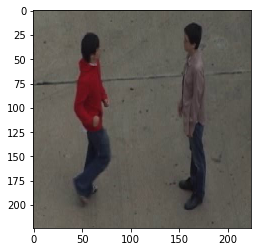

In [36]:
filename = 'FramesTemp/frame1.jpg'
im_ele = tf.contrib.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
print  (type(im_ele))
ima_elep = tf.contrib.keras.preprocessing.image.img_to_array(im_ele)
ima_elep = np.expand_dims(ima_elep, axis=0);
plt.imshow(im_ele);

In [37]:
model_resNet50_conv1 = tf.keras.models.Model(inputs=model_ResNet50.input, 
                                          outputs=model_ResNet50.get_layer('conv1').output)

In [38]:
features = model_ResNet50.predict(ima_elep)
features_conv1 = model_resNet50_conv1.predict(ima_elep)
print (features.shape)
print (features_conv1.shape, features_conv1.shape[3])

(1, 1000)
(1, 112, 112, 64) 64


## 15 filtros de la primera capa elegidos al azar

In [39]:
perm = np.random.permutation(range(features_conv1.shape[3]))[0:15]

In [ ]:
perm

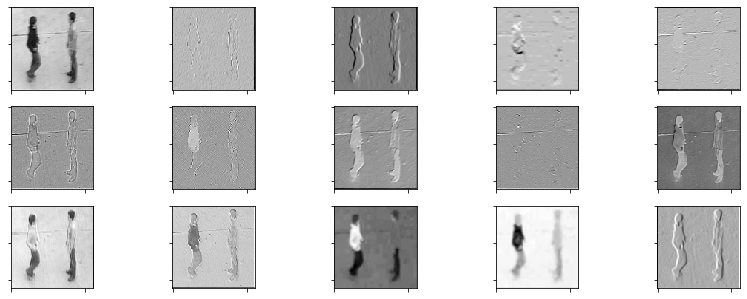

In [40]:
fig = plt.figure(figsize=(14,7))
for i in range(15):
    ax=fig.add_subplot(4,5,i+1)
    plt.imshow(features_conv1[0,:,:, perm[i]], interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

In [ ]:
x=1
np.save('binarycovsfe/'+ list_elements1[0].split("/")[-1][:-4] ,x)

In [ ]:
'binarycovsfe/'+ list_elements1[0].split("/")[-1][:-4]+"/"+filename.split("/")[-1][:-4]

In [ ]:
filename = "FramesTemp/frame%d.jpg"
filename.split("/")[-1][:-4]

In [ ]:
vidcap = cv2.VideoCapture('Datasets/datasets/ut/segmented_set1/'+list_elements2[17][:-4]+'.avi')
success,image = vidcap.read()
count = 1
success = True
while success:
    cv2.imwrite("Trayectorias_densas/frames2/frame%d.jpg" % count, image)     # save frame as JPEG file      
    success,image = vidcap.read()
    #print('Read a new frame: ', success)
    count += 1

In [ ]:
for i in range(len(list_elements1)):
    os.makedirs('binaryfe/'+list_elements1[i].split("/")[-1][:-4])

## Test Preliminar

In [16]:
perm = np.random.permutation(63)[0:15]

In [17]:
model_resNet50_conv1 = tf.keras.models.Model(inputs=model_ResNet50.input, 
                                          outputs=model_ResNet50.get_layer('conv1').output)

In [18]:
list_elements1,list_elements2=dirr_carps('Datasets/exp01/')
path='FramesTemp/'
path2=list_elements2[17][:-4]
area=20

In [19]:
trayectorias=tr_text(list_elements1[17])

In [20]:
vidcap = cv2.VideoCapture('Datasets/datasets/ut/segmented_set1/'+list_elements2[17][:-4]+'.avi')
success,image = vidcap.read()
count = 1
success = True
while success:
        filename = "FramesTemp/frame%d.jpg" % count
        cv2.imwrite(filename, image)     # save frame as JPEG file     
        x,y,z=cv2.imread("FramesTemp/frame1.jpg").shape
        conv1_im = tf.contrib.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
        conv1_im = tf.contrib.keras.preprocessing.image.img_to_array(conv1_im)
        conv1_im = np.expand_dims(conv1_im, axis=0);
        features = model_ResNet50.predict(conv1_im)
        features_conv1 = model_resNet50_conv1.predict(conv1_im)
        convimg=[]
        for i in range(15):
            convimg.append(cv2.resize(features_conv1[0,:,:,perm[i]], (y, x),interpolation = cv2.INTER_CUBIC))
        #Guardo las 20 caracteristicas de cada frame
        np.save('binaryfe/'+ list_elements1[17].split("/")[-1][:-4]+"/"+filename.split("/")[-1][:-4],convimg)    
        success,image = vidcap.read()
        #print('Read a new frame: ', success)
        count += 1

In [21]:
covs_,matrix_,great_p_,great_q_=video_covs_x16(path,trayectorias,area,path2)
np.save('binarycovsfe/'+ list_elements2[17][:-4],covs_)
del(covs_)
del(matrix_)
del(great_p_)
del(great_q_)

In [24]:
temp=np.load('binarycovsfe/'+ list_elements2[17][:-4]+'.npy')

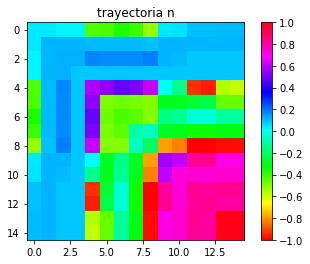

In [51]:
plt.title('trayectoria n')
plt.imshow(pintar(temp[0]),cmap="hsv")
plt.colorbar(ticks=[1,0.8,0.6,0.4,0.2,0,-0.2,-0.4,-0.6,-0.8,-1])

# 15 filtros de la primera capa elegidos al azar


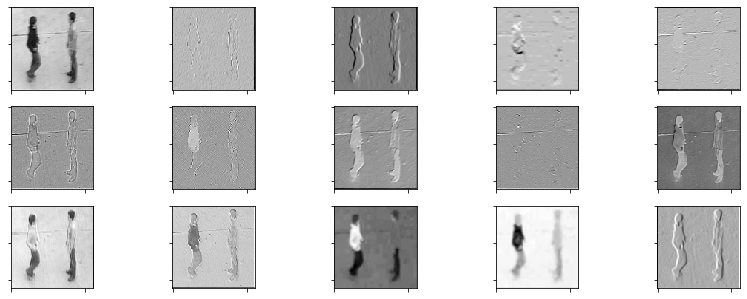

In [59]:
fig = plt.figure(figsize=(14,7))
for i in range(15):
    ax=fig.add_subplot(4,5,i+1)
    plt.imshow(features_conv1[0,:,:, perm[i]], interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

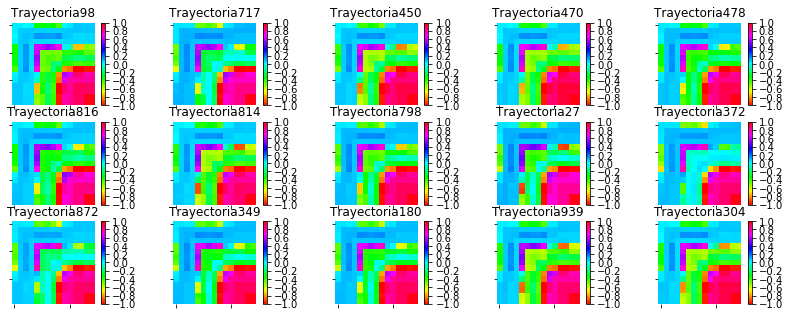

In [58]:
fig = plt.figure(figsize=(14,7))
order = np.random.permutation(943)[0:15]
for i in range(15):
    ax=fig.add_subplot(4,5,i+1)
    plt.title('Trayectoria'+str(order[i]))
    plt.imshow(pintar(temp[order[i]]),cmap="hsv")
    #plt.grid()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.box(False)
    #plt.axis("Off")
    plt.colorbar(ticks=[1,0.8,0.6,0.4,0.2,0,-0.2,-0.4,-0.6,-0.8,-1])

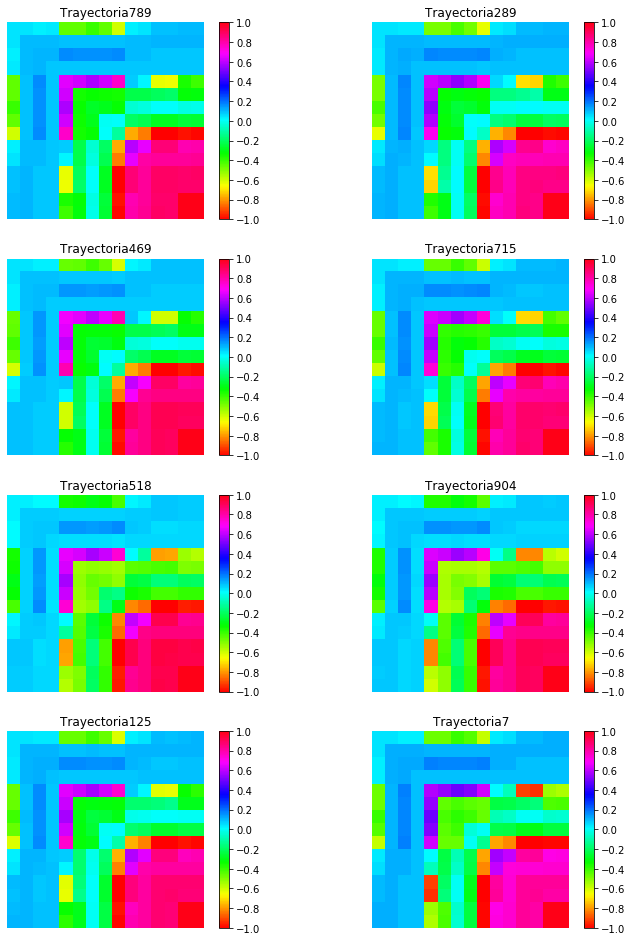

In [57]:
fig=plt.figure(figsize=(12,21))
order = np.random.permutation(943)[0:15]
for i in range(8):
    fig.add_subplot(int(str(52)+str(i+1)))
    plt.title('Trayectoria'+str(order[i]))
    plt.imshow(pintar(temp[order[i]]),cmap="hsv")
    #plt.grid()
    plt.box(False)
    plt.axis("Off")
    plt.colorbar(ticks=[1,0.8,0.6,0.4,0.2,0,-0.2,-0.4,-0.6,-0.8,-1])
  

In [ ]:
np.save('binarycovsfe/'+ list_elements2[17][:-4],covs_)

In [ ]:
print(len(covs_))
print(matrix_.shape)
print(len(great_p_))
print(len(great_q_))
print(great_p_[0].shape)
print(covs_[0][0].shape[0])
print(great_q_[0].shape)

### EXPERIMENTO

In [ ]:
features_conv1[0,:,:,perm[0]].shape

In [ ]:
convimg=[]
for i in range(20):
    convimg.append(features_conv1[0,:,:,perm[i]])

In [ ]:
import gc
gc.collect()


In [ ]:
del(covs_)
del(matrix_)
del(great_p_)
del(great_q_)

In [ ]:
perm = np.random.permutation(range(64))[0:15]

In [ ]:
perm.shape

In [ ]:
list_elements1,list_elements2=dirr_carps('Datasets/exp01/')
path='FramesTemp/'
perm = np.random.permutation(range(features_conv1.shape[3]))[0:15]
area=20

In [ ]:

model_resNet50_conv1 = tf.keras.models.Model(inputs=model_ResNet50.input, 
                                          outputs=model_ResNet50.get_layer('conv1').output)

for i in tqdm(range(len(list_elements1))):
    trayectorias=tr_text(list_elements1[i])
    path2=list_elements2[i][:-4]
    #print(path)
    #Eliminando frames de la carpeta 
    folder = path 
    for the_file in os.listdir(folder): 
        file_path = os.path.join(folder, the_file) 
        try: 
            if os.path.isfile(file_path): 
                os.unlink(file_path) 
         #elif os.path.isdir(file_path): shutil.rmtree(file_path) 
        except Exception as e: 
            print(e)
    #print('flag')
    
    #Obteniendo frames        
    print(list_elements2[i][:-4])
    
    vidcap = cv2.VideoCapture('Datasets/datasets/ut/segmented_set1/'+list_elements2[i][:-4]+'.avi')
    success,image = vidcap.read()
    count = 1
    success = True
    while success:
        filename = "FramesTemp/frame%d.jpg" % count
        cv2.imwrite(filename, image)     # save frame as JPEG file     
        x,y,z=cv2.imread("FramesTemp/frame1.jpg").shape
        conv1_im = tf.contrib.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
        conv1_im = tf.contrib.keras.preprocessing.image.img_to_array(conv1_im)
        conv1_im = np.expand_dims(conv1_im, axis=0);
        features = model_ResNet50.predict(conv1_im)
        features_conv1 = model_resNet50_conv1.predict(conv1_im)
        convimg=[]
        for j in range(15):
            convimg.append(cv2.resize(features_conv1[0,:,:,perm[j]], (y, x),interpolation = cv2.INTER_CUBIC))
        #Guardo las 20 caracteristicas de cada frame
        np.save('binaryfe/'+ list_elements2[i][:-4]+"/"+filename.split("/")[-1][:-4],convimg)    
        success,image = vidcap.read()
        #print('Read a new frame: ', success)
        count += 1
    
    
    
    #Extrayendo covarianzas    
    covs,matrix,great_p,great_q=video_covs_x16(path,trayectorias,area,path2)
    np.save('binarycovsfe/'+ list_elements2[i][:-4],covs)
    #recupero el espacio de nuevo
    del(covs)
    del(matrix)
    del(great_p)
    del(great_q)

In [ ]:
np.load("binaryfe/0_1_4/frame1.npy").shape

In [ ]:
'binaryfe/'+ list_elements1[i].split("/")[-1][:-4]+"/"+filename.split("/")[-1][:-4]